In [36]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
# https://iwatobipen.wordpress.com/2020/01/21/make-report-with-rdkit-and-matplotlib-rdkit-memo-chemoinformatics/
# https://iwatobipen.wordpress.com/2017/11/03/draw-high-quality-molecular-image-in-rdkit-rdkit/

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from matplotlib.backends.backend_pgf import PdfPages
import os
from PIL import Image
import io
import matplotlib.image as mpimg
import cairosvg
import shap

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedKFold, KFold
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import hp
from hyperopt import fmin, tpe, Trials, STATUS_OK
from sklearn.preprocessing import PowerTransformer
from scipy.optimize import minimize, least_squares, brute
from scipy import optimize
from scipy.stats import boxcox
import lightgbm as lgb
#import pickle

In [2]:
sns.set_style("ticks", {'xtick.direction': 'in', 'ytick.direction': 'in'})
sns.set_context("notebook", font_scale=2.2, rc={"lines.linewidth": 3.7})

from pylab import *
rc('axes', linewidth=2.5)
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 3

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Build a model with fingerprints

### Load data

In [43]:
# Rdkit 2048 (path length 7)
#df_2 = pd.read_csv('df_fin_2048.csv')
df_2 = pd.read_csv('df_fin_path_32768_3_fin.csv')
#df_2 = pd.read_csv('df_fin_path_1024_1_fin.csv')
#df_2 = pd.read_csv('df_fin_path_2048_7_short.csv')

In [24]:
# Morgan 2048 (radius 7)
#df_2 = pd.read_csv('df_fin_morgan_4096_1_fin.csv')
df_2 = pd.read_csv('df_fin_morgan_16384_3_fin.csv')

In [4]:
# PubChem 881
df_2 = pd.read_csv('df_fin_PubChem_new.csv')

In [5]:
# MACCS 166
#df_2 = pd.read_csv('df_fin_MACCS.csv')
df_2 = pd.read_csv('df_fin_MACCS_new.csv')

In [228]:
# Avalon 2048
df_2 = pd.read_csv('df_fin_Avalon_new.csv')

In [156]:
df_2 = pd.read_csv('0514_test_4.csv')

In [6]:
df_2

,Type of MB,Types of contaminants,pH,MB MWCO (Da),MB contact angle,Pressure (kPa),Measurement time (min),Initial concentration of compound (mg/L),removal rate (%),1,...,158,159,160,161,162,163,164,165,166,167
0,AK,2(2butoxyethoxy)ethanol,7.0,150,50.0,800.0,10.0,0.16223,81.59,0,...,1,0,1,1,0,0,0,1,0,0
1,AK,caprolactam,7.0,150,50.0,800.0,10.0,0.11316,82.85,0,...,0,1,0,0,1,0,0,1,1,0
2,AK,creatine,7.0,150,50.0,800.0,10.0,0.13114,96.65,0,...,1,1,1,1,1,0,0,1,0,0
3,AK,formaldehyde,7.0,150,50.0,800.0,10.0,0.03003,3.35,0,...,0,0,0,0,0,0,0,1,0,0
4,AK,isopropanol,7.0,150,50.0,800.0,10.0,0.06010,65.27,0,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,XLE440,trichloroethylene,8.0,150,39.8,410.0,2880.0,0.10000,3.00,0,...,0,0,0,0,0,0,0,0,0,0
1902,XLE440,chloroform,8.0,150,39.8,410.0,10.0,0.10000,10.00,0,...,0,0,0,0,0,0,0,0,0,0
1903,XLE440,carbontetrachloride,8.0,150,39.8,410.0,10.0,0.10000,69.00,0,...,0,0,0,0,0,0,0,0,0,0
1904,XLE440,perchloroethylene,8.0,150,39.8,410.0,10.0,0.10000,71.00,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_2.drop(labels=['Types of contaminants'], axis=1, inplace=True)
#df_2.drop(labels=['PCA_size'], axis=1, inplace=True)

In [7]:
y_data = df_2['removal rate (%)']
x_data = df_2.copy()
x_data.drop(columns=['removal rate (%)'], inplace=True)

(array([  5.,   7.,   3.,   5.,   7.,   5.,  11.,   1.,   9.,   8.,   6.,
          6.,   4.,   4.,   8.,   9.,   7.,   8.,  10.,   8.,   4.,  12.,
          8.,   3.,   2.,   6.,   6.,   5.,   5.,   6.,   5.,  12.,   6.,
          7.,   3.,   2.,   4.,   7.,   9.,  11.,   3.,   5.,   7.,   4.,
         10.,   5.,   6.,   3.,   1.,   3.,  17.,   3.,   8.,   8.,   3.,
          8.,   4.,   8.,   2.,   7.,   8.,   7.,   8.,   1.,   5.,  10.,
          6.,   2.,  10.,  14.,  18.,  15.,  16.,  18.,  15.,  21.,  17.,
         12.,  25.,  18.,  17.,  32.,  31.,  31.,  29.,  16.,  32.,  31.,
         33.,  49.,  45.,  45.,  65.,  78.,  79., 107., 106., 105.,  88.,
        272.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  4

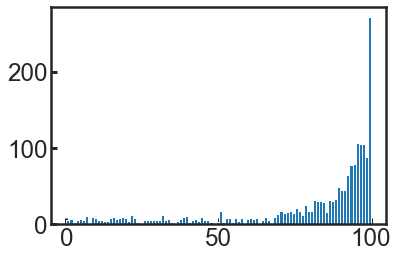

In [8]:
plt.hist(y_data, bins=100)

### Transform data before training

In [9]:
y_data_trans = y_data/100
#y_data_trans = y_data

In [10]:
#y_data_trans = np.log10(100-y_data_trans)
#y_data_trans = -np.log(1-y_data_trans)
#y_data_trans = np.log(1+y_data_trans)
y_data_trans = -np.sqrt(1-y_data_trans)
#y_data_trans = -np.cbrt(1-y_data_trans)
#y_data_trans = y_data_trans**3

(array([12.,  8., 12., 12., 16., 10., 10., 15., 15., 13., 12., 18.,  5.,
        10.,  6., 10., 14., 13., 10.,  2.,  9., 18.,  6.,  9.,  7., 14.,
         8.,  3.,  1., 20.,  9.,  9.,  8.,  6.,  9.,  6.,  5., 10., 11.,
         2.,  9.,  8.,  6.,  6., 16., 17., 18., 15., 19., 15., 21., 17.,
        12., 24., 17., 16., 24., 27., 27., 19., 26., 13., 19., 32., 10.,
        25., 37., 19., 32., 22., 34., 26., 34., 43., 30., 51., 31., 55.,
        36., 61., 31., 25., 56., 30., 26., 25., 15., 19., 19., 43., 31.,
        36., 31., 33., 18., 21.,  6.,  3.,  6., 70.]),
 array([-1.  , -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92,
        -0.91, -0.9 , -0.89, -0.88, -0.87, -0.86, -0.85, -0.84, -0.83,
        -0.82, -0.81, -0.8 , -0.79, -0.78, -0.77, -0.76, -0.75, -0.74,
        -0.73, -0.72, -0.71, -0.7 , -0.69, -0.68, -0.67, -0.66, -0.65,
        -0.64, -0.63, -0.62, -0.61, -0.6 , -0.59, -0.58, -0.57, -0.56,
        -0.55, -0.54, -0.53, -0.52, -0.51, -0.5 , -0.49, -0.48, -0.47,
        

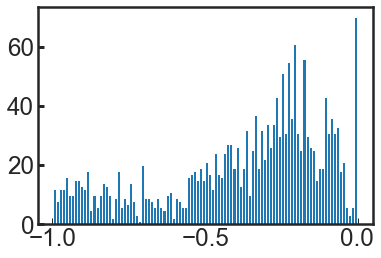

In [11]:
#scaler = preprocessing.MinMaxScaler()
#scaler.fit(b.values.reshape(-1,1))
#temp = scaler.transform(b.values.reshape(-1,1))
plt.hist(y_data_trans, bins=100)

In [12]:
y_data_trans.agg(['skew', 'kurtosis']).transpose()

skew       -0.744597
kurtosis   -0.455850
Name: removal rate (%), dtype: float64

In [13]:
y_data_trans = y_data_trans.values.reshape(-1, 1)
#y_data_trans = y_data.values.reshape(-1, 1)

### Data preprocessing

In [14]:
le_mem_name = LabelEncoder()
x_data.loc[:,'Type of MB'] = le_mem_name.fit_transform(x_data.loc[:,'Type of MB'])

scaler_mem_name = preprocessing.MinMaxScaler()
scaler_pH = preprocessing.MinMaxScaler()
scaler_MWCO = preprocessing.MinMaxScaler()
scaler_CA = preprocessing.MinMaxScaler()
scaler_pressure = preprocessing.MinMaxScaler()
scaler_time = preprocessing.MinMaxScaler()
scaler_init = preprocessing.MinMaxScaler()
scaler_removal = preprocessing.MinMaxScaler()
#scaler_removal = preprocessing.StandardScaler()

scaler_mem_name.fit(x_data.loc[:,'Type of MB'].values.reshape(-1,1))
temp_0 = scaler_mem_name.transform(x_data.loc[:,'Type of MB'].values.reshape(-1,1))
scaler_pressure.fit(x_data.loc[:,'Pressure (kPa)'].values.reshape(-1,1))
temp_1 = scaler_pressure.transform(x_data.loc[:,'Pressure (kPa)'].values.reshape(-1,1))
scaler_pH.fit(x_data.loc[:,'pH'].values.reshape(-1,1))
temp_2 = scaler_pH.transform(x_data.loc[:,'pH'].values.reshape(-1,1))
scaler_MWCO.fit(x_data.loc[:,'MB MWCO (Da)'].values.reshape(-1,1))
temp_3 = scaler_MWCO.transform(x_data.loc[:,'MB MWCO (Da)'].values.reshape(-1,1))
scaler_CA.fit(x_data.loc[:,'MB contact angle'].values.reshape(-1,1))
temp_4 = scaler_CA.transform(x_data.loc[:,'MB contact angle'].values.reshape(-1,1))
scaler_time.fit(x_data.loc[:,'Measurement time (min)'].values.reshape(-1,1))
temp_5 = scaler_time.transform(x_data.loc[:,'Measurement time (min)'].values.reshape(-1,1))
scaler_init.fit(x_data.loc[:,'Initial concentration of compound (mg/L)'].values.reshape(-1,1))
temp_6 = scaler_init.transform(x_data.loc[:,'Initial concentration of compound (mg/L)'].values.reshape(-1,1))
scaler_removal.fit(y_data_trans)
temp_8 = scaler_removal.transform(y_data_trans)
#temp_8 = y_data_trans

x_data_scaled = pd.DataFrame()
y_data_scaled = pd.DataFrame()

x_data_scaled['Type of MB'] = temp_0.reshape(1,-1).tolist()[0]
x_data_scaled['Pressure (kPa)'] = temp_1.reshape(1,-1).tolist()[0]
x_data_scaled['pH'] = temp_2.reshape(1,-1).tolist()[0]
x_data_scaled['MB MWCO (Da)'] = temp_3.reshape(1,-1).tolist()[0]
x_data_scaled['MB contact angle'] = temp_4.reshape(1,-1).tolist()[0]
x_data_scaled['Measurement time (min)'] = temp_5.reshape(1,-1).tolist()[0]
x_data_scaled['Initial concentration of compound (mg/L)'] = temp_6.reshape(1,-1).tolist()[0]
y_data_scaled = temp_8.reshape(1,-1).tolist()[0]
#y_data_scaled = y_data_trans

In [15]:
x_data.reset_index(drop=True, inplace=True)

In [16]:
x_data_scaled = pd.concat([x_data_scaled, x_data.iloc[:, 7:]], axis=1)

In [17]:
x_data_scaled

,Type of MB,Pressure (kPa),pH,MB MWCO (Da),MB contact angle,Measurement time (min),Initial concentration of compound (mg/L),1,2,3,...,872,873,874,875,876,877,878,879,880,881
0,0.0,0.171779,0.545455,0.21519,0.547692,0.00000,0.000081,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.171779,0.545455,0.21519,0.547692,0.00000,0.000056,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.171779,0.545455,0.21519,0.547692,0.00000,0.000065,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.171779,0.545455,0.21519,0.547692,0.00000,0.000015,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.171779,0.545455,0.21519,0.547692,0.00000,0.000030,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,1.0,0.052147,0.659091,0.21519,0.390769,0.49913,0.000050,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1902,1.0,0.052147,0.659091,0.21519,0.390769,0.00000,0.000050,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1903,1.0,0.052147,0.659091,0.21519,0.390769,0.00000,0.000050,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1904,1.0,0.052147,0.659091,0.21519,0.390769,0.00000,0.000050,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([12.,  8., 12., 12., 16., 10., 10., 15., 15., 15., 10., 18.,  5.,
        10.,  6., 10., 14., 13., 10.,  5.,  6., 18.,  6.,  9.,  7., 14.,
         8.,  3.,  1., 20.,  9.,  9.,  8.,  6.,  9.,  6.,  5., 10., 11.,
         2.,  9.,  8.,  6.,  6., 16., 17., 18., 15., 19., 15., 21., 17.,
        12., 24., 17., 16., 24., 27., 27., 19., 26., 13., 19., 32., 10.,
        25., 37., 19., 32., 22., 34., 26., 34., 43., 30., 51., 31., 55.,
        36., 61., 31., 25., 56., 30., 26., 25., 15., 19., 19., 43., 30.,
        37., 31., 33., 18., 21.,  6.,  3.,  6., 70.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.

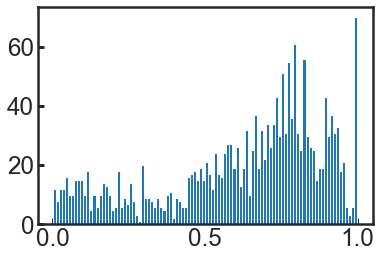

In [18]:
plt.hist(y_data_scaled, bins=100)

In [19]:
# stratified splits

mini = np.amin(y_data_scaled)
maxi = np.amax(y_data_scaled)
bins = np.linspace(start=mini, stop=maxi, num=5)
y_binned = np.digitize(y_data_scaled, bins, right=True)
x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data_scaled, test_size=0.2, random_state=6, stratify=y_binned)

## Traing the model with incremental (repetitive) learning in loops

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Early stopping is not available in dart mode


[1]	training's rmse: 0.253406	training's huber: 0.0321074	valid_0's rmse: 0.2574	valid_0's huber: 0.0331275
[2]	training's rmse: 0.241133	training's huber: 0.0290727	valid_0's rmse: 0.245549	valid_0's huber: 0.0301471
[3]	training's rmse: 0.229949	training's huber: 0.0264382	valid_0's rmse: 0.23435	valid_0's huber: 0.0274599
[4]	training's rmse: 0.21991	training's huber: 0.0241802	valid_0's rmse: 0.224509	valid_0's huber: 0.0252022
[5]	training's rmse: 0.209983	training's huber: 0.0220463	valid_0's rmse: 0.214294	valid_0's huber: 0.0229609
[6]	training's rmse: 0.20228	training's huber: 0.0204587	valid_0's rmse: 0.206592	valid_0's huber: 0.0213402
[7]	training's rmse: 0.194497	training's huber: 0.0189146	valid_0's rmse: 0.198981	valid_0's huber: 0.0197968
[8]	training's rmse: 0.197589	training's huber: 0.0195207	valid_0's rmse: 0.201925	valid_0's huber: 0.0203869
[9]	training's rmse: 0.191311	training's huber: 0.0183	valid_0's rmse: 0.196035	valid_0's huber: 0.0192149
[10]	training's rm

[101]	training's rmse: 0.138474	training's huber: 0.00958751	valid_0's rmse: 0.154924	valid_0's huber: 0.0120007
[102]	training's rmse: 0.140635	training's huber: 0.00988908	valid_0's rmse: 0.156828	valid_0's huber: 0.0122974
[103]	training's rmse: 0.142886	training's huber: 0.0102082	valid_0's rmse: 0.158803	valid_0's huber: 0.0126092
[104]	training's rmse: 0.136105	training's huber: 0.00926226	valid_0's rmse: 0.152769	valid_0's huber: 0.0116692
[105]	training's rmse: 0.150754	training's huber: 0.0113633	valid_0's rmse: 0.166301	valid_0's huber: 0.013828
[106]	training's rmse: 0.152188	training's huber: 0.0115806	valid_0's rmse: 0.167523	valid_0's huber: 0.014032
[107]	training's rmse: 0.154696	training's huber: 0.0119654	valid_0's rmse: 0.169808	valid_0's huber: 0.0144173
[108]	training's rmse: 0.146406	training's huber: 0.0107173	valid_0's rmse: 0.162175	valid_0's huber: 0.0131504
[109]	training's rmse: 0.148098	training's huber: 0.0109666	valid_0's rmse: 0.163687	valid_0's huber: 0

[208]	training's rmse: 0.0950267	training's huber: 0.00451504	valid_0's rmse: 0.120352	valid_0's huber: 0.00724232
[209]	training's rmse: 0.096425	training's huber: 0.00464889	valid_0's rmse: 0.121419	valid_0's huber: 0.00737132
[210]	training's rmse: 0.0976887	training's huber: 0.00477154	valid_0's rmse: 0.122395	valid_0's huber: 0.00749023
[211]	training's rmse: 0.0991704	training's huber: 0.00491739	valid_0's rmse: 0.12358	valid_0's huber: 0.00763602
[212]	training's rmse: 0.0966411	training's huber: 0.00466975	valid_0's rmse: 0.121627	valid_0's huber: 0.00739661
[213]	training's rmse: 0.0942594	training's huber: 0.00444241	valid_0's rmse: 0.119549	valid_0's huber: 0.00714594
[214]	training's rmse: 0.0923485	training's huber: 0.00426412	valid_0's rmse: 0.118334	valid_0's huber: 0.00700144
[215]	training's rmse: 0.0906745	training's huber: 0.00411093	valid_0's rmse: 0.117235	valid_0's huber: 0.00687201
[216]	training's rmse: 0.091845	training's huber: 0.00421775	valid_0's rmse: 0.118

[289]	training's rmse: 0.0754842	training's huber: 0.00284893	valid_0's rmse: 0.108188	valid_0's huber: 0.00585227
[290]	training's rmse: 0.0748435	training's huber: 0.00280078	valid_0's rmse: 0.107751	valid_0's huber: 0.00580512
[291]	training's rmse: 0.0741899	training's huber: 0.00275207	valid_0's rmse: 0.107288	valid_0's huber: 0.00575536
[292]	training's rmse: 0.0749033	training's huber: 0.00280525	valid_0's rmse: 0.107745	valid_0's huber: 0.00580447
[293]	training's rmse: 0.0755616	training's huber: 0.00285478	valid_0's rmse: 0.108184	valid_0's huber: 0.00585185
[294]	training's rmse: 0.0748876	training's huber: 0.00280407	valid_0's rmse: 0.10774	valid_0's huber: 0.0058039
[295]	training's rmse: 0.0755364	training's huber: 0.00285288	valid_0's rmse: 0.108165	valid_0's huber: 0.00584979
[296]	training's rmse: 0.0762225	training's huber: 0.00290493	valid_0's rmse: 0.108615	valid_0's huber: 0.00589863
[297]	training's rmse: 0.0754581	training's huber: 0.00284696	valid_0's rmse: 0.10

[419]	training's rmse: 0.0644904	training's huber: 0.00207951	valid_0's rmse: 0.100801	valid_0's huber: 0.00508041
[420]	training's rmse: 0.0649061	training's huber: 0.0021064	valid_0's rmse: 0.101046	valid_0's huber: 0.00510511
[421]	training's rmse: 0.0644927	training's huber: 0.00207966	valid_0's rmse: 0.100763	valid_0's huber: 0.00507654
[422]	training's rmse: 0.0640844	training's huber: 0.00205341	valid_0's rmse: 0.100587	valid_0's huber: 0.0050589
[423]	training's rmse: 0.0636909	training's huber: 0.00202827	valid_0's rmse: 0.100339	valid_0's huber: 0.00503395
[424]	training's rmse: 0.0633622	training's huber: 0.00200738	valid_0's rmse: 0.100054	valid_0's huber: 0.00500537
[425]	training's rmse: 0.0637289	training's huber: 0.00203069	valid_0's rmse: 0.100286	valid_0's huber: 0.00502862
[426]	training's rmse: 0.0633717	training's huber: 0.00200798	valid_0's rmse: 0.100124	valid_0's huber: 0.00501241
[427]	training's rmse: 0.0630589	training's huber: 0.00198821	valid_0's rmse: 0.09

[528]	training's rmse: 0.0591197	training's huber: 0.00174757	valid_0's rmse: 0.0981919	valid_0's huber: 0.00482082
[529]	training's rmse: 0.0587617	training's huber: 0.00172647	valid_0's rmse: 0.0981035	valid_0's huber: 0.00481215
[530]	training's rmse: 0.0583808	training's huber: 0.00170416	valid_0's rmse: 0.0978512	valid_0's huber: 0.00478743
[531]	training's rmse: 0.0587107	training's huber: 0.00172348	valid_0's rmse: 0.0980308	valid_0's huber: 0.00480502
[532]	training's rmse: 0.0583606	training's huber: 0.00170298	valid_0's rmse: 0.0978676	valid_0's huber: 0.00478903
[533]	training's rmse: 0.0586835	training's huber: 0.00172188	valid_0's rmse: 0.0980337	valid_0's huber: 0.00480531
[534]	training's rmse: 0.0582862	training's huber: 0.00169864	valid_0's rmse: 0.0978149	valid_0's huber: 0.00478388
[535]	training's rmse: 0.0579672	training's huber: 0.0016801	valid_0's rmse: 0.0975635	valid_0's huber: 0.00475931
[536]	training's rmse: 0.0582446	training's huber: 0.00169622	valid_0's r

[608]	training's rmse: 0.0596003	training's huber: 0.0017761	valid_0's rmse: 0.0988985	valid_0's huber: 0.00489046
[609]	training's rmse: 0.0591091	training's huber: 0.00174694	valid_0's rmse: 0.098687	valid_0's huber: 0.00486956
[610]	training's rmse: 0.0586482	training's huber: 0.00171981	valid_0's rmse: 0.0984472	valid_0's huber: 0.00484593
[611]	training's rmse: 0.0581767	training's huber: 0.00169227	valid_0's rmse: 0.098274	valid_0's huber: 0.00482889
[612]	training's rmse: 0.0578125	training's huber: 0.00167114	valid_0's rmse: 0.0979949	valid_0's huber: 0.0048015
[613]	training's rmse: 0.0580914	training's huber: 0.0016873	valid_0's rmse: 0.0981479	valid_0's huber: 0.0048165
[614]	training's rmse: 0.0577728	training's huber: 0.00166885	valid_0's rmse: 0.0979998	valid_0's huber: 0.00480198
[615]	training's rmse: 0.0573537	training's huber: 0.00164472	valid_0's rmse: 0.0978269	valid_0's huber: 0.00478505
[616]	training's rmse: 0.0570338	training's huber: 0.00162643	valid_0's rmse: 

[692]	training's rmse: 0.0554012	training's huber: 0.00153465	valid_0's rmse: 0.0966381	valid_0's huber: 0.00466946
[693]	training's rmse: 0.055044	training's huber: 0.00151492	valid_0's rmse: 0.0964669	valid_0's huber: 0.00465293
[694]	training's rmse: 0.0547242	training's huber: 0.00149737	valid_0's rmse: 0.0964055	valid_0's huber: 0.00464701
[695]	training's rmse: 0.0549773	training's huber: 0.00151125	valid_0's rmse: 0.096541	valid_0's huber: 0.00466008
[696]	training's rmse: 0.0546264	training's huber: 0.00149202	valid_0's rmse: 0.0963268	valid_0's huber: 0.00463943
[697]	training's rmse: 0.0543217	training's huber: 0.00147542	valid_0's rmse: 0.0961252	valid_0's huber: 0.00462003
[698]	training's rmse: 0.0540693	training's huber: 0.00146174	valid_0's rmse: 0.0959273	valid_0's huber: 0.00460103
[699]	training's rmse: 0.0543128	training's huber: 0.00147494	valid_0's rmse: 0.0960613	valid_0's huber: 0.00461389
[700]	training's rmse: 0.0540284	training's huber: 0.00145953	valid_0's rm

[780]	training's rmse: 0.052839	training's huber: 0.00139598	valid_0's rmse: 0.0950755	valid_0's huber: 0.00451968
[781]	training's rmse: 0.0525507	training's huber: 0.00138079	valid_0's rmse: 0.0949612	valid_0's huber: 0.00450881
[782]	training's rmse: 0.0522461	training's huber: 0.00136483	valid_0's rmse: 0.0947894	valid_0's huber: 0.00449252
[783]	training's rmse: 0.0524982	training's huber: 0.00137803	valid_0's rmse: 0.0949124	valid_0's huber: 0.00450418
[784]	training's rmse: 0.0527409	training's huber: 0.0013908	valid_0's rmse: 0.0950323	valid_0's huber: 0.00451557
[785]	training's rmse: 0.0524332	training's huber: 0.00137462	valid_0's rmse: 0.0949778	valid_0's huber: 0.00451039
[786]	training's rmse: 0.0526705	training's huber: 0.00138709	valid_0's rmse: 0.0950931	valid_0's huber: 0.00452135
[787]	training's rmse: 0.0529064	training's huber: 0.00139955	valid_0's rmse: 0.0952074	valid_0's huber: 0.00453222
[788]	training's rmse: 0.0531521	training's huber: 0.00141257	valid_0's rm

[876]	training's rmse: 0.0504314	training's huber: 0.00127167	valid_0's rmse: 0.0941751	valid_0's huber: 0.00443447
[877]	training's rmse: 0.0506364	training's huber: 0.00128202	valid_0's rmse: 0.0942712	valid_0's huber: 0.00444353
[878]	training's rmse: 0.0503576	training's huber: 0.00126794	valid_0's rmse: 0.094131	valid_0's huber: 0.00443032
[879]	training's rmse: 0.0505578	training's huber: 0.00127805	valid_0's rmse: 0.0942233	valid_0's huber: 0.00443902
[880]	training's rmse: 0.0507899	training's huber: 0.00128981	valid_0's rmse: 0.0943505	valid_0's huber: 0.00445101
[881]	training's rmse: 0.0510311	training's huber: 0.00130209	valid_0's rmse: 0.0944667	valid_0's huber: 0.00446198
[882]	training's rmse: 0.0507265	training's huber: 0.00128659	valid_0's rmse: 0.0943815	valid_0's huber: 0.00445394
[883]	training's rmse: 0.0509449	training's huber: 0.00129769	valid_0's rmse: 0.094486	valid_0's huber: 0.0044638
[884]	training's rmse: 0.0506562	training's huber: 0.00128302	valid_0's rms

[968]	training's rmse: 0.048614	training's huber: 0.00118166	valid_0's rmse: 0.0933879	valid_0's huber: 0.00436065
[969]	training's rmse: 0.0487813	training's huber: 0.00118981	valid_0's rmse: 0.0934664	valid_0's huber: 0.00436798
[970]	training's rmse: 0.0485846	training's huber: 0.00118023	valid_0's rmse: 0.0933864	valid_0's huber: 0.00436051
[971]	training's rmse: 0.048373	training's huber: 0.00116997	valid_0's rmse: 0.0932612	valid_0's huber: 0.00434882
[972]	training's rmse: 0.048222	training's huber: 0.00116268	valid_0's rmse: 0.0931187	valid_0's huber: 0.00433555
[973]	training's rmse: 0.0484016	training's huber: 0.00117136	valid_0's rmse: 0.0932152	valid_0's huber: 0.00434453
[974]	training's rmse: 0.048579	training's huber: 0.00117996	valid_0's rmse: 0.0932978	valid_0's huber: 0.00435224
[975]	training's rmse: 0.048752	training's huber: 0.00118838	valid_0's rmse: 0.0933723	valid_0's huber: 0.00435919
[976]	training's rmse: 0.0485481	training's huber: 0.00117846	valid_0's rmse:

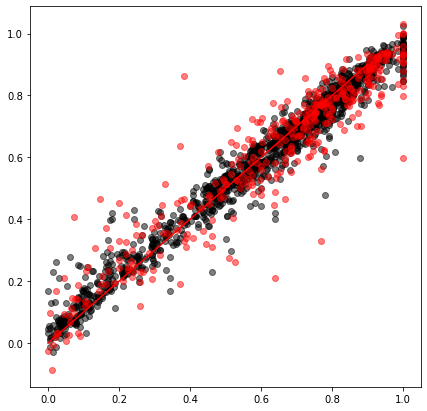

More than one metric available, picking one to plot.


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='huber'>

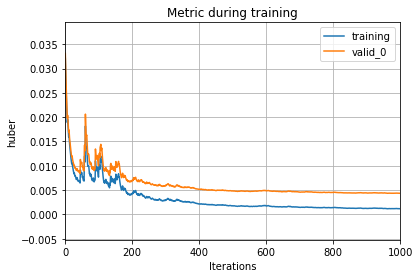

In [75]:
# incremental learning 

import timeit
start = timeit.default_timer()

params = {"objective":"reg:logistic", 'tree_method':'gpu_hist', 'booster': 'dart', 'one_drop':1}#,'colsample_bytree': 0.3,'learning_rate': 0.1, 
         # 'max_depth': 5, 'alpha': 10}#, 'process_type': 'update', 'updater': 'refresh', 'refresh_leaf': True}
        # reg:pseudohubererror, reg:squaredlogerror, reg:squarederror, reg:gamma, reg:logistic, reg:tweedie
err_list = []
err_list_test = []
res = {}
model = None

for i in range(100):
    x_train_half, x_test_dummy, y_train_half, y_test_dummy = train_test_split(x_train, y_train, test_size=0.5, random_state=i)
    
    for j in range(len(y_train_half)):
        if y_train_half[j]==np.amax(y_train):
            #print('1')
            #y_train_half[j] = np.absolute(np.random.normal(np.mean(y_train_half)*0.01, np.std(y_train_half)*0.01, 1))
            np.random.seed(6)
            y_train_half[j] = 1 - np.absolute(np.random.normal(0.01, 0.005, 1))
    #y_train_half_noise = y_train_half + np.absolute(np.random.normal(0.001, 0.005, len(y_train_half)))
    xgtrain = xgb.DMatrix(x_train_half, y_train_half, feature_names=x_train_half.columns)
    xgtest = xgb.DMatrix(x_test_dummy, y_test_dummy, feature_names=x_test_dummy.columns)
    
    model = xgb.train(params=params, dtrain=xgtrain, num_boost_round=10, xgb_model=model, evals_result=res)
    pred_train = model.predict(xgtrain)
    pred_test = model.predict(xgtest)
    train_err = mean_squared_error(y_true=y_train_half, y_pred=pred_train)
    test_err = mean_squared_error(y_true=y_test_dummy, y_pred=pred_test)
    print(i, test_err)
    err_list.append(train_err)
    err_list_test.append(test_err)

stop = timeit.default_timer()
print('Time: ', stop - start)

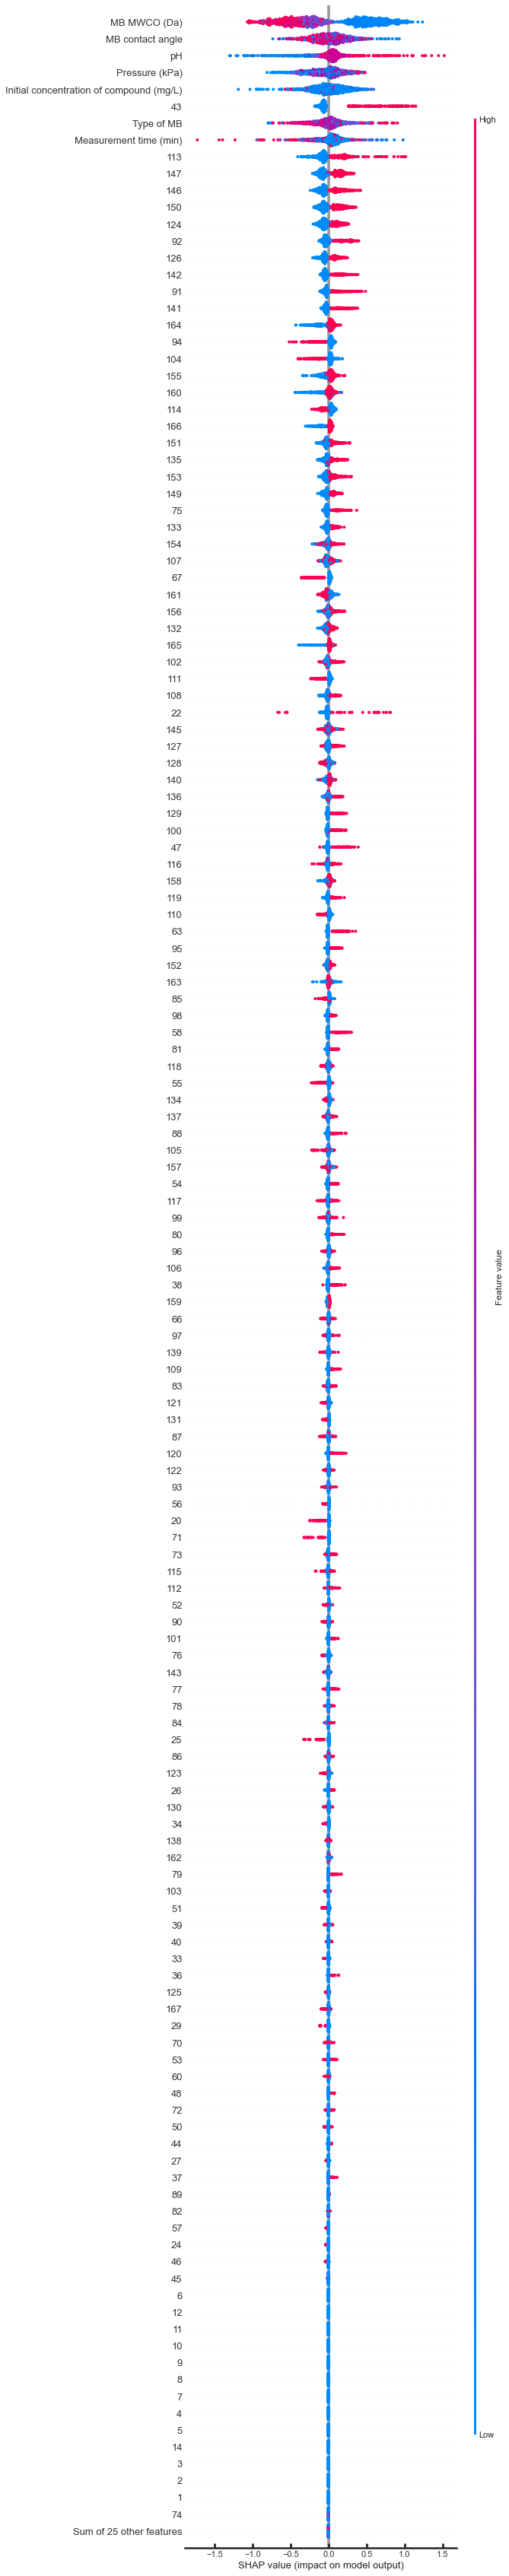

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(x_train)
shap.plots.beeswarm(shap_values, max_display=150, order=shap_values.abs.mean(0), show=False)
#plt.savefig('sqrt_shap_path_3.pdf', format='pdf', dpi=1000, bbox_inches='tight')

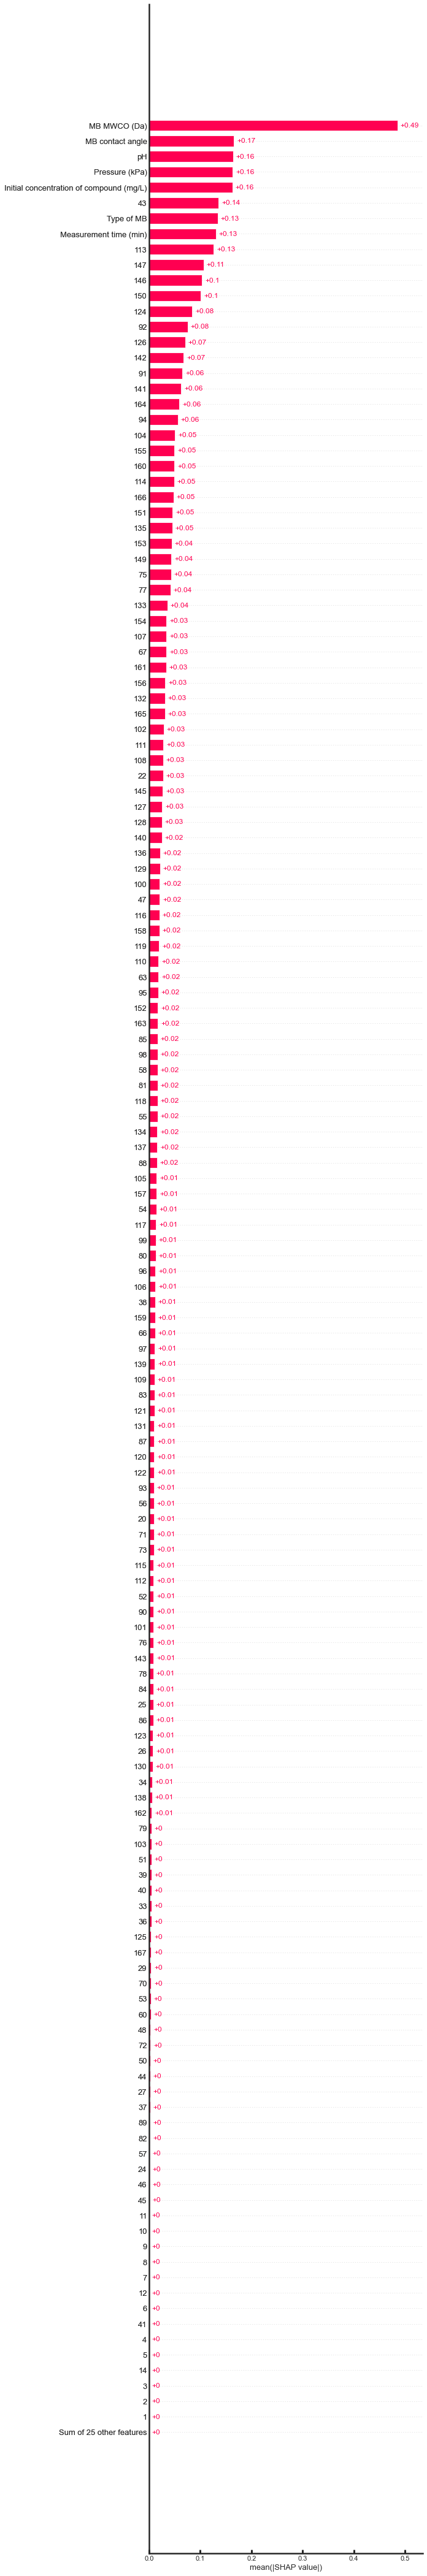

In [21]:
shap.plots.bar(shap_values, max_display=150)

In [118]:
shap_output = model.predict(xgtrain, pred_contribs=True)
shap_values = shap_output[:, :-1]
expected_value = shap_output[0, -1]
shap.summary_plot(shap_values)

In [60]:
err_list

[array([0.02527281]),
 array([0.01953101]),
 array([0.01621675]),
 array([0.01444325]),
 array([0.01310027]),
 array([0.01171205]),
 array([0.01026854]),
 array([0.00871715]),
 array([0.00846953]),
 array([0.00830227]),
 array([0.0070988]),
 array([0.00846027]),
 array([0.00681146]),
 array([0.00810187]),
 array([0.00675437]),
 array([0.00648379]),
 array([0.00693574]),
 array([0.00565544]),
 array([0.00567689]),
 array([0.00487182]),
 array([0.00523677]),
 array([0.00543703]),
 array([0.0050082]),
 array([0.00537941]),
 array([0.00462093]),
 array([0.00465358]),
 array([0.00535866]),
 array([0.00492184]),
 array([0.0045229]),
 array([0.00408383]),
 array([0.00396947]),
 array([0.00434908]),
 array([0.00405782]),
 array([0.00342307]),
 array([0.00345252]),
 array([0.00375045]),
 array([0.00373575]),
 array([0.00417106]),
 array([0.003404]),
 array([0.00339489]),
 array([0.00365232]),
 array([0.00317461]),
 array([0.00352655]),
 array([0.00313633]),
 array([0.00338344]),
 array([0.00350

In [61]:
err_list_test

[0.042705416355070684,
 0.02607499157339286,
 0.020814484239693967,
 0.018613644174175832,
 0.015032414557948907,
 0.014147816407768144,
 0.014150179292885935,
 0.013781282651877811,
 0.012910415508653945,
 0.01188688695073857,
 0.01250906401709291,
 0.009699746044867381,
 0.010687674115043516,
 0.008747902956422245,
 0.009233657732847237,
 0.00876449238117673,
 0.007862382000716421,
 0.008636070383064789,
 0.007912045812896845,
 0.00826778289610513,
 0.007507767587757283,
 0.006911683498320772,
 0.0070384531363425805,
 0.006459447823894163,
 0.006917203732877606,
 0.006866294866529096,
 0.0058256797731578635,
 0.005852224972423281,
 0.005894929313337799,
 0.005916247472167675,
 0.005943082623018982,
 0.00529133642625394,
 0.005460277389716891,
 0.005853595161663077,
 0.005878380167367452,
 0.00529323862459972,
 0.00517222751624653,
 0.004487158025329287,
 0.005183163923108736,
 0.005095918932575979,
 0.004815018394622102,
 0.005176362292340361,
 0.004652674246399287,
 0.00487321808908

### Model evaluation

In [21]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
print(mean_squared_error(y_true=y_train, y_pred=pred_train))
print(mean_squared_error(y_true=y_test, y_pred=pred_test))

0.001085678195760016
0.010172912154138777


0.0026162589523399354
0.011930629089777331


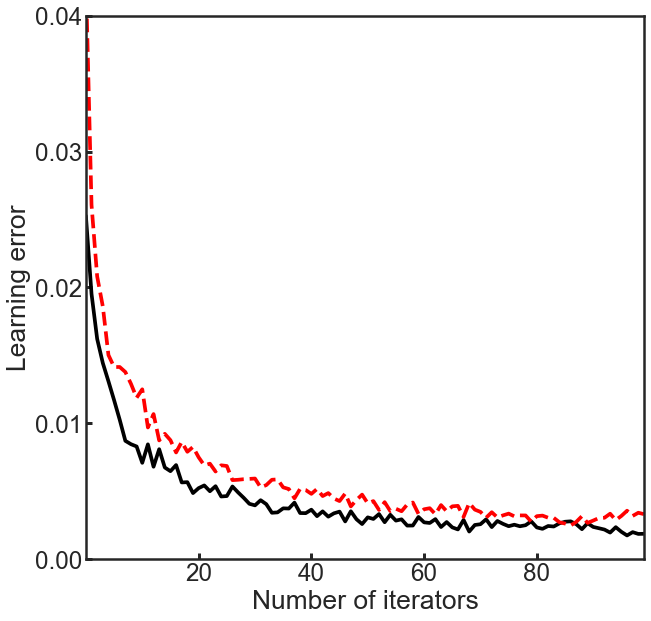

savefig() got unexpected keyword argument "bbox_i6nches" which is no longer supported as of 3.3 and will become an error in 3.6
meta NOT subset; don't know how to subset; dropped


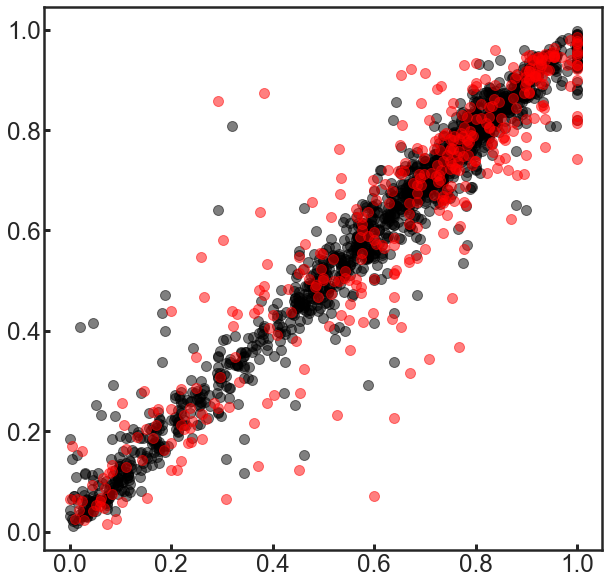

In [46]:
#y_test_noise = y_test + np.absolute(np.random.normal(np.mean(y_test)*0.01, np.std(y_test)*0.01, len(y_test)))
# pred_train = model.predict(xgb.DMatrix(x_train, y_train))
# pred_test = model.predict(xgb.DMatrix(x_test, y_test))
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
print(mean_squared_error(y_true=y_train, y_pred=pred_train))
print(mean_squared_error(y_true=y_test, y_pred=pred_test))

fig = plt.figure(figsize=(10,10))
plt.plot(err_list, 'k-')
plt.plot(err_list_test, 'r--')
plt.xlabel('Number of iterators')
plt.ylabel('Learning error')
plt.xlim(0.01,99)
plt.ylim(0,0.04)
#plt.xticks(np.arange(0,99,20))
plt.yticks(np.arange(0,0.0401,0.01))
plt.show()
fig.savefig('sqrt_fig_0_path_3.pdf', bbox_i6nches='tight', transparent=True)

plt.figure(figsize=(10,10))
plt.scatter(y_train, pred_train, c='k', alpha=0.5, s=100)
plt.scatter(y_test, pred_test, c='r', alpha=0.5, s=100)
#plt.plot(np.arange(0, 1.01, 0.1), np.arange(0, 1.01, 0.1), 'r-')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.show()

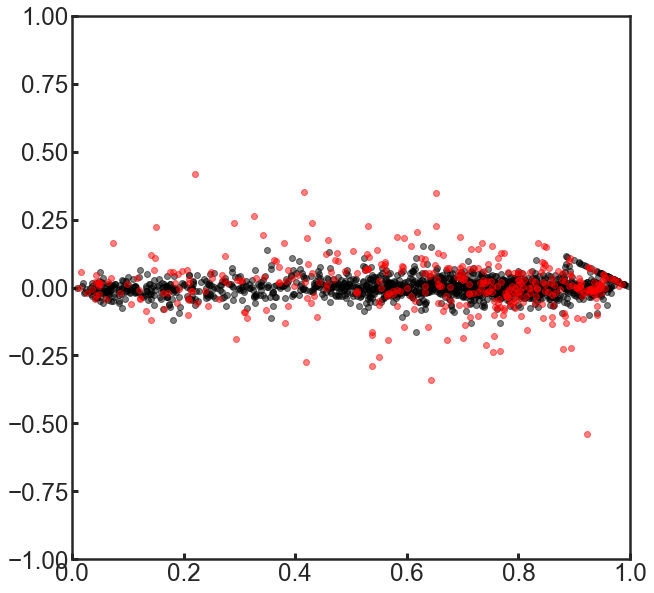

0.0010120640302584394
0.009279640857029002


In [91]:
plt.figure(figsize=(10,10))
plt.plot(pred_train, y_train-pred_train, 'ko', alpha=0.5)
plt.plot(pred_test, y_test-pred_test, 'ro', alpha=0.5)
plt.xlim(0,1)
plt.ylim(-1,1)
plt.show()

print(np.sum((y_train-pred_train)**2)/1524)
print(np.sum((y_test-pred_test)**2)/382)

In [47]:
tau, p_value = stats.kendalltau(y_test, pred_test)
print(stats.spearmanr(y_test, pred_test))
print(tau)
print(r2_score(y_test, pred_test))

SpearmanrResult(correlation=0.9075248026298885, pvalue=3.07466901749497e-145)
0.751241229294651
0.8376002516581201


In [48]:
pred_train_inverse = scaler_removal.inverse_transform(pred_train.reshape(1,-1))
pred_test_inverse = scaler_removal.inverse_transform(pred_test.reshape(1,-1))
y_train_inverse = scaler_removal.inverse_transform(np.reshape(y_train, (1,-1)))
y_test_inverse = scaler_removal.inverse_transform(np.reshape(y_test, (1,-1)))

In [40]:
# #log
# pred_train_real_scale = (1-np.exp(-pred_train_inverse))*100
# pred_test_real_scale = (1-np.exp(-pred_test_inverse))*100
# y_train_real_scale = (1-np.exp(-y_train_inverse))*100
# y_test_real_scale = (1-np.exp(-y_test_inverse))*100

In [49]:
#sqrt
pred_train_real_scale = (1-(-pred_train_inverse)**2)*100
pred_test_real_scale = (1-(-pred_test_inverse)**2)*100
y_train_real_scale = (1-(-y_train_inverse)**2)*100
y_test_real_scale = (1-(-y_test_inverse)**2)*100

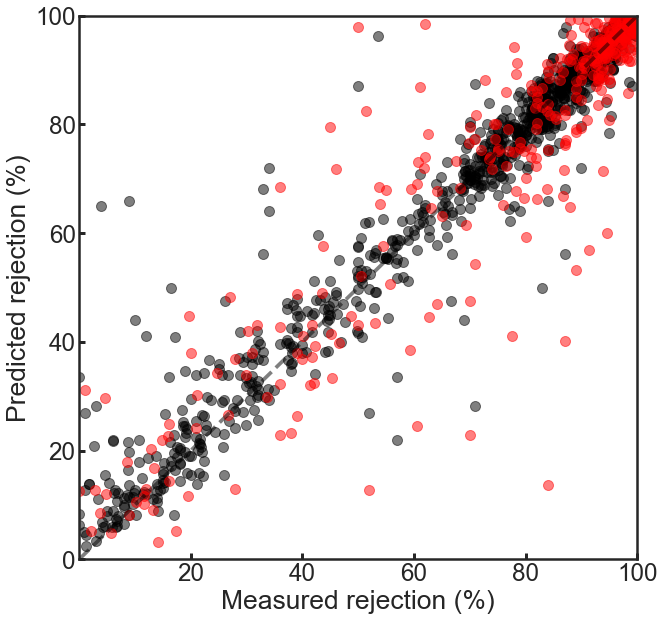

savefig() got unexpected keyword argument "bbox_i6nches" which is no longer supported as of 3.3 and will become an error in 3.6
meta NOT subset; don't know how to subset; dropped


In [50]:
fig = plt.figure(figsize=(10,10))
plt.plot(np.arange(0, 100.01, 0.1), np.arange(0, 100.01, 0.1), 'k--', alpha=0.5)
plt.scatter(y_train_real_scale, pred_train_real_scale, c='k', alpha=0.5, s=100)
plt.scatter(y_test_real_scale, pred_test_real_scale, c='r', alpha=0.5, s=100)
plt.xlim(0.01,100)
plt.ylim(0,100)
plt.xlabel('Measured rejection (%)')
plt.ylabel('Predicted rejection (%)')
plt.show()
fig.savefig("sqrt_fig_1_path_3.pdf", bbox_i6nches='tight', transparent=True)

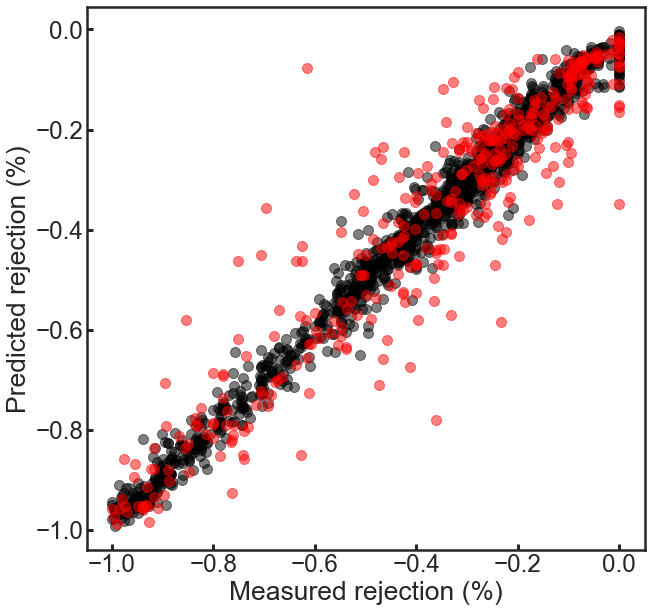

In [108]:
fig = plt.figure(figsize=(10,10))
plt.scatter(y_train_inverse, pred_train_inverse, c='k', alpha=0.5, s=100)
plt.scatter(y_test_inverse, pred_test_inverse, c='r', alpha=0.5, s=100)
#plt.plot(np.arange(0, 1.01, 0.1), np.arange(0, 1.01, 0.1), 'r-')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.xlabel('Measured rejection (%)')
plt.ylabel('Predicted rejection (%)')
plt.show()

In [51]:
#tau, p_value = stats.kendalltau(y_test_real_scale, pred_test_real_scale)
print(stats.spearmanr(y_train_real_scale[0], pred_train_real_scale[0]))
print(stats.spearmanr(y_test_real_scale[0], pred_test_real_scale[0]))
print(r2_score(y_train_real_scale[0], pred_train_real_scale[0]))
print(r2_score(y_test_real_scale[0], pred_test_real_scale[0]))
print(mean_squared_error(y_train_real_scale, pred_train_real_scale, squared=False))
print(mean_squared_error(y_test_real_scale, pred_test_real_scale, squared=False))

SpearmanrResult(correlation=0.9789347093971613, pvalue=0.0)
SpearmanrResult(correlation=0.9075248026298885, pvalue=3.07466901749497e-145)
0.9573213977126478
0.8374637629327765
2.6002030463749337
6.026294380234923


In [57]:
tau, p_value = stats.kendalltau(y_test_inverse, pred_test_inverse)
print(stats.spearmanr(y_test_inverse[0], pred_test_inverse[0]))
print(tau)
print(r2_score(y_test_inverse[0], pred_test_inverse[0]))
print(mean_squared_error(y_test_inverse[0], pred_test_inverse[0], squared=False))

SpearmanrResult(correlation=0.9167640429791172, pvalue=1.5718797451721199e-153)
0.7639477705359597
0.8642933525965555
0.09984804292351211


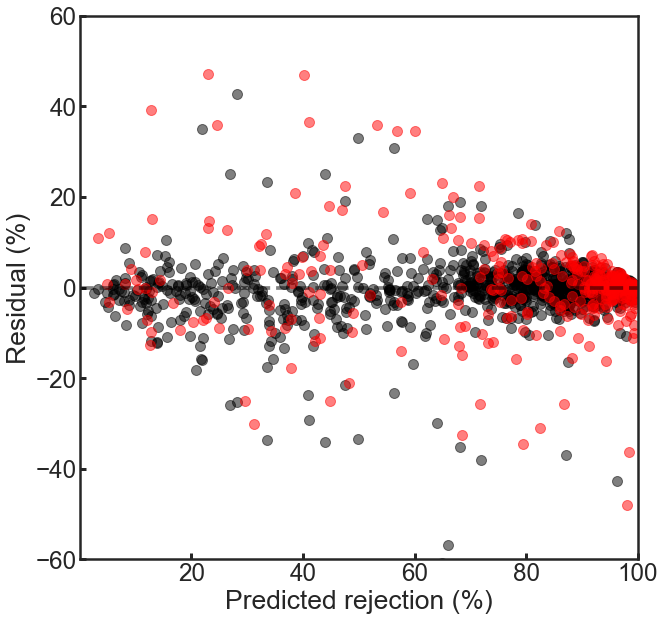

savefig() got unexpected keyword argument "bbox_i6nches" which is no longer supported as of 3.3 and will become an error in 3.6
meta NOT subset; don't know how to subset; dropped


In [52]:
fig = plt.figure(figsize=(10,10))
plt.plot(np.arange(0, 100.01, 0.1), np.zeros(1001), 'k--', alpha=0.5)
plt.scatter(pred_train_real_scale, y_train_real_scale-pred_train_real_scale, c='k', s=100, alpha=0.5)
plt.scatter(pred_test_real_scale, y_test_real_scale-pred_test_real_scale, c='r', s=100, alpha=0.5)
plt.xlabel('Predicted rejection (%)')
plt.ylabel('Residual (%)')
plt.xlim(0.01,100)
plt.ylim(-60,60)
plt.show()
fig.savefig("sqrt_residual_path_3.pdf", bbox_i6nches='tight', transparent=True)

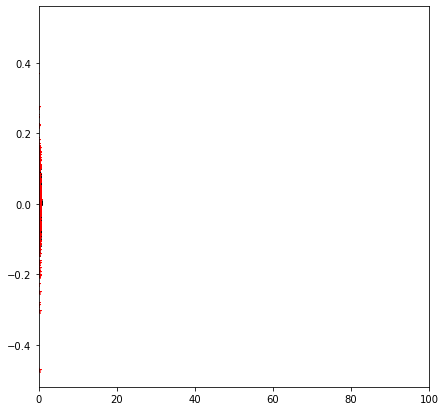

In [59]:
plt.figure(figsize=(7,7))
plt.plot(pred_train_inverse, y_train_inverse-pred_train_inverse, 'k^')
plt.plot(pred_test_inverse, y_test_inverse-pred_test_inverse, 'r*')
plt.xlim(0,100)
#plt.ylim(-1,1)
plt.show()

In [16]:
tau, p_value = stats.kendalltau(y_test, pred_test)
print(stats.spearmanr(y_test, pred_test))
print(tau)

SpearmanrResult(correlation=0.8598106953003057, pvalue=5.647392399783467e-113)
0.693094346217264
